In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('CBBdata19-23.csv')

## Questions I intend to explore
1. Which statistic(s) correlates most with wins?
2. How much does strength of schedule impact winning?
3. Which teams/conferences have won the most over the past 5 seasons?
4. Does defensive efficiency or offensive efficiency matter more?

In [5]:
# Select numerical columns to calculate correlation
selected_columns = ['AdjOE', 'AdjDE', 'EFG%', 'EFGD%', 'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD',
                    '2P%', '2P%D', '3P%', '3P%D', '3PR', '3PRD']
selected_data = df[['Wins'] + selected_columns]

# Calculate correlation matrix
correlation_matrix = selected_data.corr()

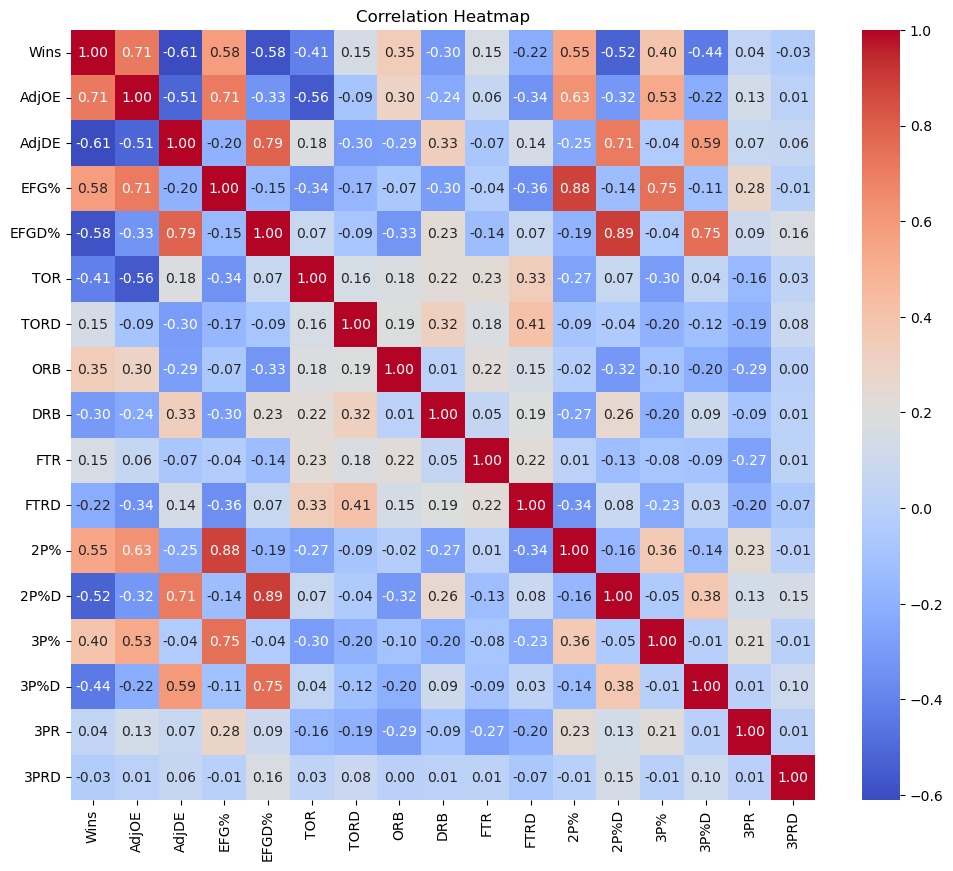

In [7]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
# Calculate correlation between 'SoS' and 'Wins'
correlation = df['SoS'].corr(df['Wins'])
print(f"Correlation between SoS and Wins: {correlation}")

Correlation between SoS and Wins: 0.28703465001740247


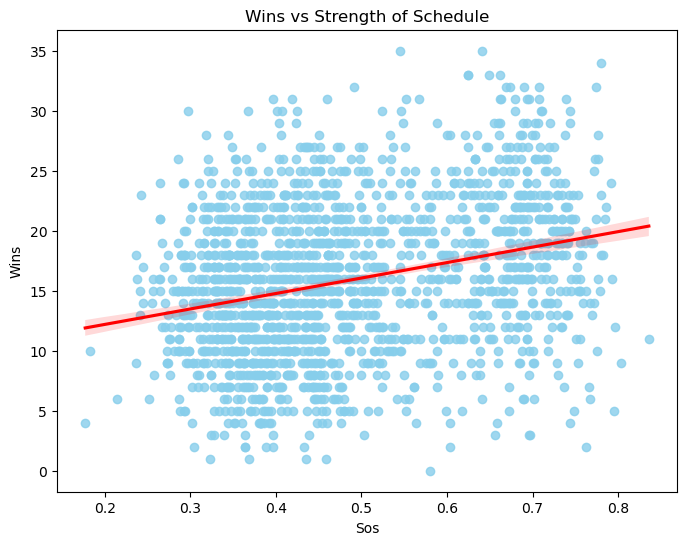

In [11]:
# Regression Plot
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='SoS', y='Wins', scatter_kws={'color': 'skyblue'}, line_kws={'color': 'red'})
plt.title('Wins vs Strength of Schedule')
plt.xlabel('Sos')
plt.ylabel('Wins')
plt.show()

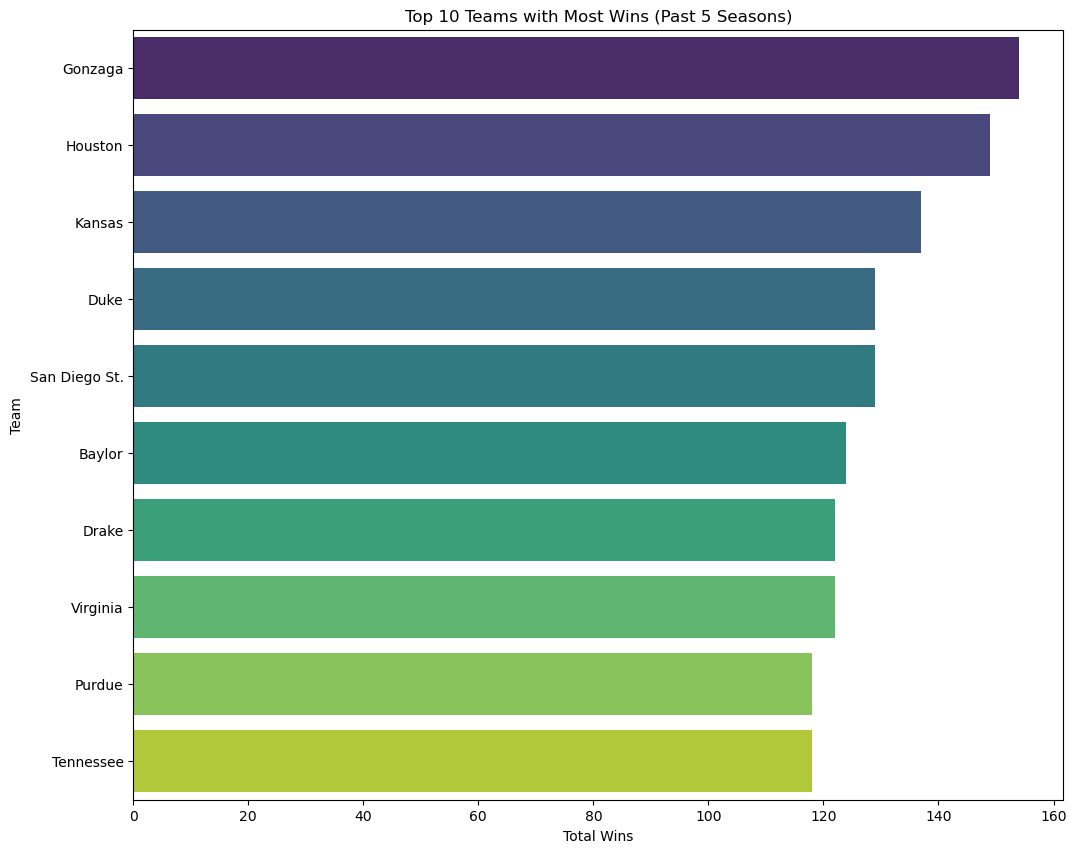

In [20]:
# Aggregate wins by teams
team_wins = df.groupby('Team')['Wins'].sum().reset_index()
team_wins_sorted = team_wins.sort_values(by='Wins', ascending=False)

# Visualization - Bar plot for top teams
plt.figure(figsize=(12, 10))
sns.barplot(data=team_wins_sorted.head(10), x='Wins', y='Team', palette='viridis')
plt.title('Top 10 Teams with Most Wins (Past 5 Seasons)')
plt.xlabel('Total Wins')
plt.ylabel('Team')
plt.show()

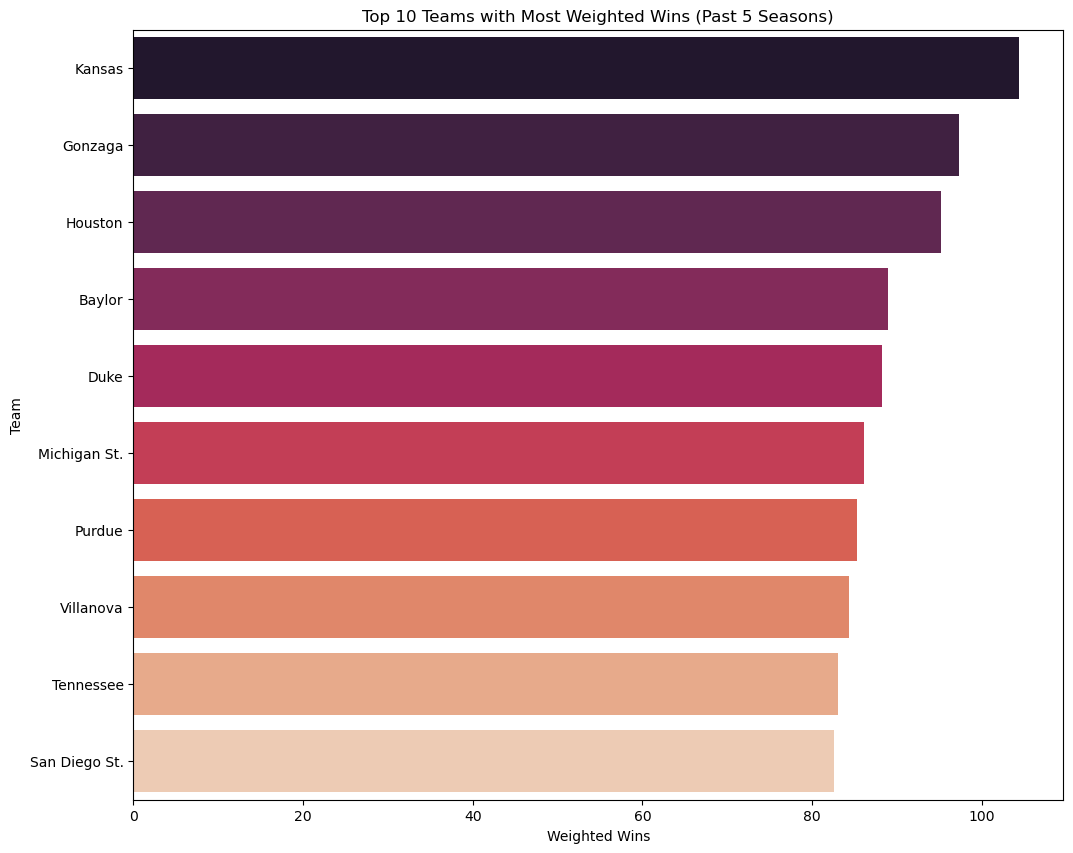

In [21]:
# Calculate weighted wins by multiplying wins with SoS for each team
df['WeightedWins'] = df['Wins'] * df['SoS']

# Aggregate weighted wins by teams
weighted_team_wins = df.groupby('Team')['WeightedWins'].sum().reset_index()
weighted_team_wins_sorted = weighted_team_wins.sort_values(by='WeightedWins', ascending=False)

# Visualization - Bar plot for top teams with weighted wins
plt.figure(figsize=(12, 10))
sns.barplot(data=weighted_team_wins_sorted.head(10), x='WeightedWins', y='Team', palette='rocket')
plt.title('Top 10 Teams with Most Weighted Wins (Past 5 Seasons)')
plt.xlabel('Weighted Wins')
plt.ylabel('Team')
plt.show()

/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_84660/196105758.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  conf_summary = df.groupby('Conf')['Wins', 'Team'].agg({'Wins': 'sum', 'Team': 'nunique'}).reset_index()


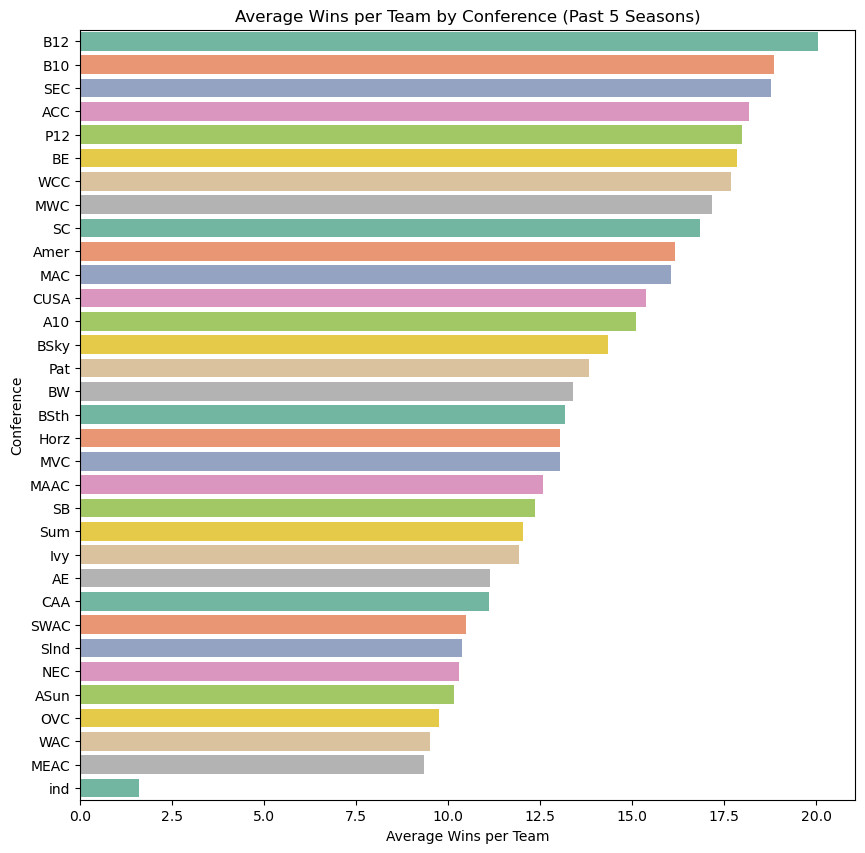

In [25]:
# Calculate total wins and number of unique teams per conference
conf_summary = df.groupby('Conf')['Wins', 'Team'].agg({'Wins': 'sum', 'Team': 'nunique'}).reset_index()
conf_summary.columns = ['Conf', 'TotalWins', 'NumTeams']

# Calculate average wins per team per season
conf_summary['AvgWinsPerTeamPerSeason'] = conf_summary['TotalWins'] / (conf_summary['NumTeams'] * 5)

# Visualization - Bar plot for average wins per team per season by conference
plt.figure(figsize=(10, 10))
sns.barplot(data=conf_summary.sort_values(by='AvgWinsPerTeamPerSeason', ascending=False),
            x='AvgWinsPerTeamPerSeason', y='Conf', palette='Set2')
plt.title('Average Wins per Team by Conference (Past 5 Seasons)')
plt.xlabel('Average Wins per Team')
plt.ylabel('Conference')
plt.show()

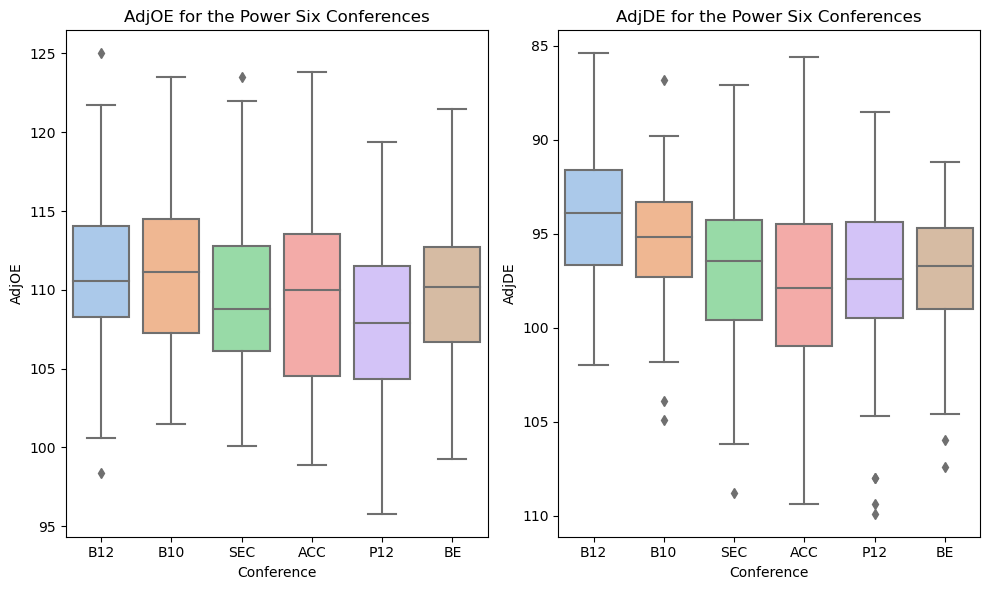

In [66]:
# Filter dataset for the top six conferences
top_six_conferences = ['B12', 'B10', 'SEC', 'ACC', 'P12', 'BE']
top_six_conferences_data = df[df['Conf'].isin(top_six_conferences)]

# Visualization - Box plot for AdjOE and AdjDE for the top six conferences
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=top_six_conferences_data, x='Conf', y='AdjOE', order=top_six_conferences, palette='pastel')
plt.title('AdjOE for the Power Six Conferences')
plt.xlabel('Conference')
plt.ylabel('AdjOE')

plt.subplot(1, 2, 2)
sns.boxplot(data=top_six_conferences_data, x='Conf', y='AdjDE', order=top_six_conferences, palette='pastel')
plt.title('AdjDE for the Power Six Conferences')
plt.xlabel('Conference')
plt.ylabel('AdjDE')

# Invert y-axis for AdjDE plot
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

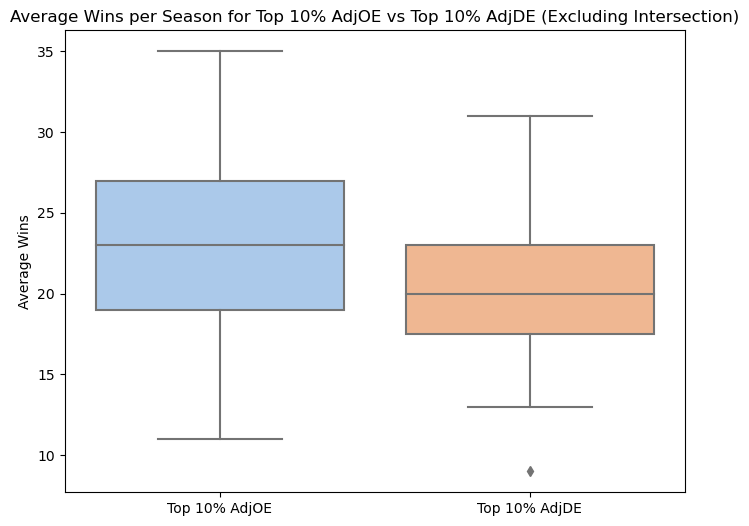

In [62]:
# Calculate the threshold values for the top 10% in AdjOE and bottom 10% in AdjDE
top_10_AdjOE = df['AdjOE'].quantile(0.9)
bottom_10_AdjDE = df['AdjDE'].quantile(0.1)

# Filter dataset for top 10% in AdjOE and bottom 10% in AdjDE
top_10_AdjOE_data = df[df['AdjOE'] >= top_10_AdjOE]
bottom_10_AdjDE_data = df[df['AdjDE'] <= bottom_10_AdjDE]

# Exclude teams that are in the top 10% for AdjOE and bottom 10% for AdjDE
exclude_both = pd.merge(top_10_AdjOE_data, bottom_10_AdjDE_data, how='inner', on='Team')['Team']
filtered_AdjOE_data = top_10_AdjOE_data[~top_10_AdjOE_data['Team'].isin(exclude_both)]
filtered_AdjDE_data = bottom_10_AdjDE_data[~bottom_10_AdjDE_data['Team'].isin(exclude_both)]

# Calculate average wins for top 10% in AdjOE and bottom 10% in AdjDE excluding the intersection
avg_wins_top_AdjOE = filtered_AdjOE_data['Wins'].mean()
avg_wins_bottom_AdjDE = filtered_AdjDE_data['Wins'].mean()

# Visualization - Box plot for average wins excluding teams in top 10% for AdjOE and bottom 10% for AdjDE
plt.figure(figsize=(8, 6))
sns.boxplot(data=[filtered_AdjOE_data['Wins'], filtered_AdjDE_data['Wins']], palette='pastel')
plt.xticks([0, 1], ['Top 10% AdjOE', 'Top 10% AdjDE'])
plt.title('Average Wins per Season for Top 10% AdjOE vs Top 10% AdjDE (Excluding Intersection)')
plt.ylabel('Average Wins')
plt.show()